# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run144', 'ORACLE.run138', 'ORACLE.run150', 'ORACLE.run120', 'ORACLE.run126', 'ORACLE.run114', 'ORACLE.run18', 'ORACLE.run132'}


{'Wisig_3', 'Wisig_1', 'Wisig_4', 'Wisig_2'}


tensor([[[-1.5184,  0.4536, -0.1972,  ...,  1.0057, -0.0789, -0.4141],
         [-0.4141,  0.8085,  0.0592,  ...,  1.8931,  0.3352,  1.4395]],

        [[-0.0573,  1.6054, -0.1720,  ..., -0.9174, -0.4969,  0.7071],
         [ 0.4396, -2.2552, -1.3570,  ...,  0.1147, -1.2232,  0.9174]],

        [[ 0.3796,  0.2797, -0.2198,  ...,  0.3196,  0.1998, -0.2397],
         [-1.2985, -1.3585,  0.6792,  ...,  0.0599,  0.2597,  0.1398]],

        ...,

        [[ 1.4444, -0.2015,  0.4703,  ..., -1.1085, -0.1344,  1.3772],
         [ 0.2351,  1.9315,  0.1680,  ...,  0.3863, -0.5543, -1.2429]],

        [[ 0.7070, -0.8080, -0.2357,  ...,  0.3367,  0.3872,  0.1178],
         [ 0.4882, -1.1447,  0.7407,  ..., -1.8517, -0.9763,  0.1178]],

        [[ 0.9297,  0.7776, -0.7099,  ...,  0.5747,  0.5747,  1.0818],
         [-0.1014, -0.5578, -0.3381,  ...,  0.1521, -0.0169, -0.4733]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.5064, train_label_loss: 2.8092, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3029.3305, train_label_loss: 1.3686, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 2983.3433, train_label_loss: 0.6404, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 2976.5789, train_label_loss: 1.6940, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 2939.4042, train_label_loss: 0.9117, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 2972.8578, train_label_loss: 0.6367, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 2966.7480, train_label_loss: 0.9154, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 2955.7240, train_label_loss: 1.1267, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 2988.6621, train_label_loss: 0.4916, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3306.5111, train_label_loss: 0.6608, 


epoch: 1, source_val_acc_label: 0.6495, target_val_acc_label: 0.6922, source_val_label_loss: 0.9389, target_val_label_loss: 5.9937, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.8936, train_label_loss: 1.2452, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3451.1084, train_label_loss: 0.5191, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3406.3142, train_label_loss: 0.8456, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 3694.2582, train_label_loss: 0.7038, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3925.6385, train_label_loss: 0.5900, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3975.0977, train_label_loss: 0.7379, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3941.8386, train_label_loss: 0.6102, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 3945.2788, train_label_loss: 0.5039, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3681.9746, train_label_loss: 1.3458, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3000.2981, train_label_loss: 0.4769, 


epoch: 2, source_val_acc_label: 0.6722, target_val_acc_label: 0.6998, source_val_label_loss: 0.8637, target_val_label_loss: 6.8602, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.7791, train_label_loss: 0.4955, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 3114.1331, train_label_loss: 0.5842, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 2989.1075, train_label_loss: 1.3805, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 2986.0784, train_label_loss: 0.5974, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 2975.8980, train_label_loss: 0.6755, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 2969.5858, train_label_loss: 0.7334, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 2945.0186, train_label_loss: 0.5339, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 3357.7617, train_label_loss: 0.9714, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3617.0589, train_label_loss: 0.6144, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3008.9234, train_label_loss: 0.9871, 


epoch: 3, source_val_acc_label: 0.6993, target_val_acc_label: 0.7326, source_val_label_loss: 0.8040, target_val_label_loss: 7.4240, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.7890, train_label_loss: 0.9691, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3067.3348, train_label_loss: 0.4637, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3025.8929, train_label_loss: 0.9969, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3018.7022, train_label_loss: 0.3755, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 2999.0023, train_label_loss: 0.6141, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3021.2623, train_label_loss: 0.6888, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3021.8786, train_label_loss: 0.6870, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 3303.0445, train_label_loss: 0.8040, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3656.3005, train_label_loss: 0.2745, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3014.4711, train_label_loss: 0.5731, 


epoch: 4, source_val_acc_label: 0.7168, target_val_acc_label: 0.7439, source_val_label_loss: 0.7742, target_val_label_loss: 8.7228, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.7771, train_label_loss: 0.5738, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 3072.2821, train_label_loss: 0.5233, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 3030.2027, train_label_loss: 0.4340, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3033.0303, train_label_loss: 0.7980, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3011.8065, train_label_loss: 0.5025, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3041.8708, train_label_loss: 0.8668, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3030.3865, train_label_loss: 0.6637, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 3242.9642, train_label_loss: 0.5921, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3598.8224, train_label_loss: 0.7068, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 2991.4178, train_label_loss: 0.2674, 


epoch: 5, source_val_acc_label: 0.7169, target_val_acc_label: 0.7600, source_val_label_loss: 0.7701, target_val_label_loss: 8.8087, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.7788, train_label_loss: 0.3960, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3147.6664, train_label_loss: 0.9769, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3026.8707, train_label_loss: 0.6890, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 2990.3989, train_label_loss: 0.5120, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 2977.4839, train_label_loss: 0.4980, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 3031.6059, train_label_loss: 0.3607, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 3033.3338, train_label_loss: 0.5851, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 3302.7431, train_label_loss: 0.2965, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3611.0083, train_label_loss: 0.8905, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3014.4995, train_label_loss: 0.6342, 


epoch: 6, source_val_acc_label: 0.7249, target_val_acc_label: 0.7662, source_val_label_loss: 0.7591, target_val_label_loss: 9.1544, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.7733, train_label_loss: 0.4266, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3181.7117, train_label_loss: 0.4066, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 3050.9320, train_label_loss: 0.4632, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 2997.9770, train_label_loss: 0.6882, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 2988.3962, train_label_loss: 0.2274, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 2973.4950, train_label_loss: 0.4347, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 2977.5938, train_label_loss: 0.3463, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 3272.4660, train_label_loss: 0.7823, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3600.4908, train_label_loss: 0.4591, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3021.6426, train_label_loss: 0.4728, 


epoch: 7, source_val_acc_label: 0.7339, target_val_acc_label: 0.7797, source_val_label_loss: 0.7519, target_val_label_loss: 9.4404, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.7693, train_label_loss: 0.3286, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 3166.9188, train_label_loss: 0.3370, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 2986.2761, train_label_loss: 0.1197, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 3028.2623, train_label_loss: 0.3306, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 2979.6665, train_label_loss: 0.4368, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3013.1467, train_label_loss: 0.5625, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 3012.1610, train_label_loss: 0.3761, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3318.6010, train_label_loss: 0.2612, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3551.6563, train_label_loss: 0.3889, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3037.3581, train_label_loss: 0.1602, 


epoch: 8, source_val_acc_label: 0.7341, target_val_acc_label: 0.7800, source_val_label_loss: 0.7540, target_val_label_loss: 9.8155, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.7753, train_label_loss: 0.3946, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3194.0836, train_label_loss: 0.3649, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3018.3135, train_label_loss: 0.3943, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 3025.6480, train_label_loss: 0.4119, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3013.6577, train_label_loss: 0.5345, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3004.5628, train_label_loss: 0.3800, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 2991.5118, train_label_loss: 0.2465, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 3330.9891, train_label_loss: 0.2746, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3442.9618, train_label_loss: 0.7453, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3396.8214, train_label_loss: 0.5338, 


epoch: 9, source_val_acc_label: 0.7316, target_val_acc_label: 0.7804, source_val_label_loss: 0.7758, target_val_label_loss: 10.4158, 


New best


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.8699, train_label_loss: 0.4366, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 4061.7184, train_label_loss: 0.3120, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3939.6301, train_label_loss: 0.4929, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3933.0704, train_label_loss: 0.2752, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3907.6126, train_label_loss: 0.1848, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3999.1511, train_label_loss: 0.3106, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3991.4671, train_label_loss: 0.5829, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3859.0421, train_label_loss: 0.4314, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 3932.6638, train_label_loss: 0.2929, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3931.6013, train_label_loss: 0.4836, 


epoch: 10, source_val_acc_label: 0.7328, target_val_acc_label: 0.7852, source_val_label_loss: 0.7790, target_val_label_loss: 10.2681, 


New best


epoch: 11, [batch: 1 / 33600], examples_per_second: 1.0453, train_label_loss: 0.2937, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 4224.4613, train_label_loss: 0.5711, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 4005.7615, train_label_loss: 0.2292, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 4029.5449, train_label_loss: 0.3533, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3954.3015, train_label_loss: 0.2007, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3969.1836, train_label_loss: 0.4863, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 4029.3793, train_label_loss: 0.2878, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3935.7174, train_label_loss: 0.4684, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3956.6763, train_label_loss: 0.4780, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 4032.4929, train_label_loss: 0.5124, 


epoch: 11, source_val_acc_label: 0.7298, target_val_acc_label: 0.7824, source_val_label_loss: 0.8116, target_val_label_loss: 11.0583, 


epoch: 12, [batch: 1 / 33600], examples_per_second: 1.0406, train_label_loss: 0.4504, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 4233.4127, train_label_loss: 0.1320, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 3894.3159, train_label_loss: 0.3912, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 3981.1789, train_label_loss: 0.2469, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 3988.8971, train_label_loss: 0.2647, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 4017.2067, train_label_loss: 0.2194, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 3953.1248, train_label_loss: 0.4298, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 3916.8135, train_label_loss: 0.0718, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 3925.2979, train_label_loss: 0.4000, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 3928.2331, train_label_loss: 0.5784, 


epoch: 12, source_val_acc_label: 0.7279, target_val_acc_label: 0.7911, source_val_label_loss: 0.8233, target_val_label_loss: 11.0772, 


New best


epoch: 13, [batch: 1 / 33600], examples_per_second: 1.0392, train_label_loss: 0.2941, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 4406.9707, train_label_loss: 0.5273, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 4404.0827, train_label_loss: 0.2456, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 4246.9306, train_label_loss: 0.2272, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 4498.7601, train_label_loss: 0.3757, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 4972.7943, train_label_loss: 0.2085, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 4944.2021, train_label_loss: 0.7592, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 4976.8864, train_label_loss: 0.2037, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 5143.7195, train_label_loss: 0.1758, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 5361.9119, train_label_loss: 0.2222, 


epoch: 13, source_val_acc_label: 0.7233, target_val_acc_label: 0.7908, source_val_label_loss: 0.8562, target_val_label_loss: 11.3869, 


epoch: 14, [batch: 1 / 33600], examples_per_second: 1.3042, train_label_loss: 0.3979, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 5096.0752, train_label_loss: 0.2672, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 5129.7342, train_label_loss: 0.3193, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 5207.7647, train_label_loss: 0.1662, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 4969.9029, train_label_loss: 0.5498, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 5343.5768, train_label_loss: 0.4481, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 4973.8475, train_label_loss: 0.1264, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 4993.2501, train_label_loss: 0.2804, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 4997.2629, train_label_loss: 0.2344, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 5258.7838, train_label_loss: 0.3704, 


epoch: 14, source_val_acc_label: 0.7244, target_val_acc_label: 0.7898, source_val_label_loss: 0.8676, target_val_label_loss: 11.9761, 


epoch: 15, [batch: 1 / 33600], examples_per_second: 1.3266, train_label_loss: 0.2788, 


epoch: 15, [batch: 3360 / 33600], examples_per_second: 5415.3709, train_label_loss: 0.2766, 


epoch: 15, [batch: 6720 / 33600], examples_per_second: 5409.1181, train_label_loss: 0.2060, 


epoch: 15, [batch: 10080 / 33600], examples_per_second: 5116.8994, train_label_loss: 0.3269, 


epoch: 15, [batch: 13440 / 33600], examples_per_second: 4977.9874, train_label_loss: 0.0564, 


epoch: 15, [batch: 16800 / 33600], examples_per_second: 5045.3573, train_label_loss: 0.0324, 


epoch: 15, [batch: 20160 / 33600], examples_per_second: 5100.8454, train_label_loss: 0.2945, 


epoch: 15, [batch: 23520 / 33600], examples_per_second: 5104.9805, train_label_loss: 0.2574, 


epoch: 15, [batch: 26880 / 33600], examples_per_second: 4925.1854, train_label_loss: 0.4222, 


epoch: 15, [batch: 30240 / 33600], examples_per_second: 5017.4739, train_label_loss: 0.2263, 


epoch: 15, source_val_acc_label: 0.7274, target_val_acc_label: 0.7903, source_val_label_loss: 0.9066, target_val_label_loss: 12.4954, 


epoch: 16, [batch: 1 / 33600], examples_per_second: 1.3331, train_label_loss: 0.1528, 


epoch: 16, [batch: 3360 / 33600], examples_per_second: 5053.8795, train_label_loss: 0.1483, 


epoch: 16, [batch: 6720 / 33600], examples_per_second: 5112.9484, train_label_loss: 0.5154, 


epoch: 16, [batch: 10080 / 33600], examples_per_second: 5171.6844, train_label_loss: 0.7067, 


epoch: 16, [batch: 13440 / 33600], examples_per_second: 5416.9790, train_label_loss: 0.2127, 


epoch: 16, [batch: 16800 / 33600], examples_per_second: 5170.8250, train_label_loss: 0.2707, 


epoch: 16, [batch: 20160 / 33600], examples_per_second: 5336.3892, train_label_loss: 0.4284, 


epoch: 16, [batch: 23520 / 33600], examples_per_second: 4999.0044, train_label_loss: 0.3839, 


epoch: 16, [batch: 26880 / 33600], examples_per_second: 4959.2713, train_label_loss: 0.0868, 


epoch: 16, [batch: 30240 / 33600], examples_per_second: 4973.3953, train_label_loss: 0.0866, 


epoch: 16, source_val_acc_label: 0.7216, target_val_acc_label: 0.7906, source_val_label_loss: 0.9344, target_val_label_loss: 12.9179, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

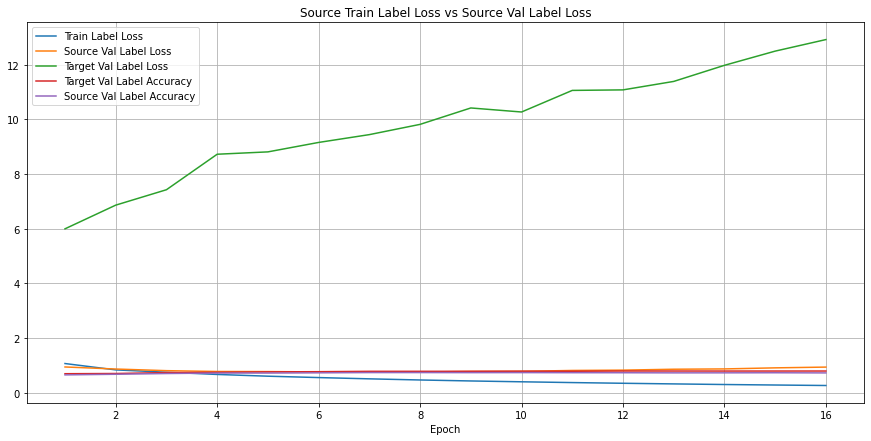

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

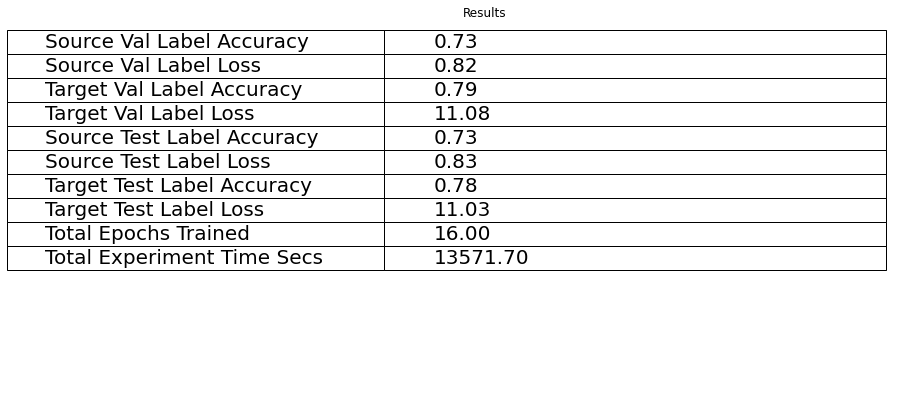

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

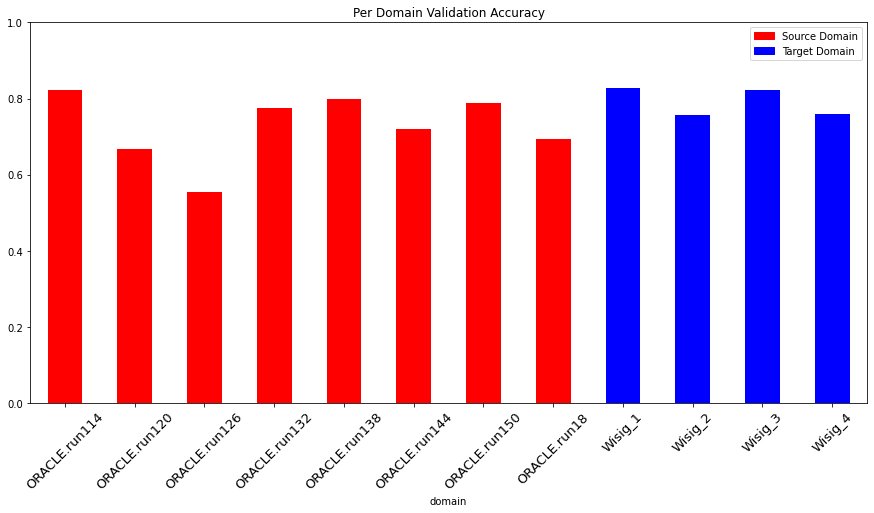

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.72720703125 Target Test Label Accuracy: 0.7826719234746639
Source Val Label Accuracy: 0.7278580729166667 Target Val Label Accuracy: 0.791106276371308


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL